# Day 5 Analysis

For seasons 1999-2021, get a distribution of point differential
- Outliers
- Is there a difference between conferences? 
- Is there a difference between divisions within a conference?
- Is there a difference between regular season and playoffs?

## Set Up

In [2]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Wrangle the data

game_type values:
CON = conference  
DIV = divisional round  
REG = regular season  
SB = superbowl  
WC = wildcard  

In [13]:
query = """
WITH data AS (
    SELECT
        game_id,
        season,
        game_type,
        CASE
            WHEN game_type = 'REG' THEN '0'
            ELSE '1'
        END AS is_playoffs,
        week,
        away_team,
        away_score,
        -- Need to update data to account for 3 teams that switched cities between 1999-2020
        CASE
            WHEN home_team = 'STL' THEN 'LAR'
            WHEN home_team = 'SD' THEN 'LAC'
            WHEN home_team = 'OAK' THEN 'LV'
            ELSE home_team
        END AS home_team,
        home_score,
        ABS(home_score - away_score) AS point_diff,
        CASE
            WHEN ABS(home_score - away_score) = 3 THEN 'field goal'
            WHEN ABS(home_score - away_score) = 7 THEN 'touchdown'
            WHEN ABS(home_score - away_score) = 14 THEN '2 touchdowns'
            WHEN ABS(home_score - away_score) >= 17 THEN '2+ posessions'
            ELSE 'other'
        END AS game_outcome,
        roof,
        CASE
            WHEN roof = "dome" THEN 1
            ELSE 0
        END as is_dome,
        surface,
        temp,
        wind,
        away_rest,
        home_rest,
        ABS(home_rest - away_rest) AS rest_diff,
        CASE
            WHEN ABS(home_rest - away_rest) < 7 THEN 1
            ELSE 0
        END AS rest_diff_LT7,
        weekday,
        div_game 
    FROM schedules
)
SELECT d.*, team_desc.team_conf AS conference, team_desc.team_division AS division
FROM data d
LEFT JOIN team_descriptions team_desc
    ON team_desc.team_abbr = d.home_team
"""

df = pd.read_sql(query, conn)

In [14]:
df

,game_id,season,game_type,is_playoffs,week,away_team,away_score,home_team,home_score,point_diff,...,temp,wind,away_rest,home_rest,rest_diff,rest_diff_LT7,weekday,div_game,conference,division
0,1999_01_MIN_ATL,1999,REG,0,1,MIN,17.0,ATL,14.0,3.0,...,NaN,NaN,7,7,0,1,Sunday,0,NFC,NFC South
1,1999_01_KC_CHI,1999,REG,0,1,KC,17.0,CHI,20.0,3.0,...,80.0,12.0,7,7,0,1,Sunday,0,NFC,NFC North
2,1999_01_PIT_CLE,1999,REG,0,1,PIT,43.0,CLE,0.0,43.0,...,78.0,12.0,7,7,0,1,Sunday,1,AFC,AFC North
3,1999_01_OAK_GB,1999,REG,0,1,OAK,24.0,GB,28.0,4.0,...,67.0,10.0,7,7,0,1,Sunday,0,NFC,NFC North
4,1999_01_BUF_IND,1999,REG,0,1,BUF,14.0,IND,31.0,17.0,...,NaN,NaN,7,7,0,1,Sunday,1,AFC,AFC South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,2021_20_LA_TB,2021,DIV,1,20,LA,30.0,TB,27.0,3.0,...,50.0,11.0,6,7,1,1,Sunday,0,NFC,NFC South
6133,2021_20_BUF_KC,2021,DIV,1,20,BUF,36.0,KC,42.0,6.0,...,35.0,6.0,8,7,1,1,Sunday,0,AFC,AFC West
6134,2021_21_CIN_KC,2021,CON,1,21,CIN,27.0,KC,24.0,3.0,...,41.0,4.0,8,7,1,1,Sunday,0,AFC,AFC West
6135,2021_21_SF_LA,2021,CON,1,21,SF,17.0,LA,20.0,3.0,...,NaN,NaN,8,7,1,1,Sunday,1,NFC,NFC West


In [15]:
df[['away_team', 'away_score', 'home_team', 'home_score','point_diff','game_outcome']]

,away_team,away_score,home_team,home_score,point_diff,game_outcome
0,MIN,17.0,ATL,14.0,3.0,field goal
1,KC,17.0,CHI,20.0,3.0,field goal
2,PIT,43.0,CLE,0.0,43.0,2+ posessions
3,OAK,24.0,GB,28.0,4.0,other
4,BUF,14.0,IND,31.0,17.0,2+ posessions
...,...,...,...,...,...,...
6132,LA,30.0,TB,27.0,3.0,field goal
6133,BUF,36.0,KC,42.0,6.0,other
6134,CIN,27.0,KC,24.0,3.0,field goal
6135,SF,17.0,LA,20.0,3.0,field goal


In [16]:
# if roof is outdoors, there is a wind reading

df[pd.notnull(df['wind'])]

,game_id,season,game_type,is_playoffs,week,away_team,away_score,home_team,home_score,point_diff,...,temp,wind,away_rest,home_rest,rest_diff,rest_diff_LT7,weekday,div_game,conference,division
1,1999_01_KC_CHI,1999,REG,0,1,KC,17.0,CHI,20.0,3.0,...,80.0,12.0,7,7,0,1,Sunday,0,NFC,NFC North
2,1999_01_PIT_CLE,1999,REG,0,1,PIT,43.0,CLE,0.0,43.0,...,78.0,12.0,7,7,0,1,Sunday,1,AFC,AFC North
3,1999_01_OAK_GB,1999,REG,0,1,OAK,24.0,GB,28.0,4.0,...,67.0,10.0,7,7,0,1,Sunday,0,NFC,NFC North
5,1999_01_SF_JAX,1999,REG,0,1,SF,3.0,JAX,41.0,38.0,...,76.0,8.0,7,7,0,1,Sunday,0,AFC,AFC South
7,1999_01_NE_NYJ,1999,REG,0,1,NE,30.0,NYJ,28.0,2.0,...,73.0,5.0,7,7,0,1,Sunday,1,AFC,AFC East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6130,2021_20_CIN_TEN,2021,DIV,1,20,CIN,19.0,TEN,16.0,3.0,...,35.0,0.0,7,13,6,1,Saturday,0,AFC,AFC South
6131,2021_20_SF_GB,2021,DIV,1,20,SF,13.0,GB,10.0,3.0,...,15.0,12.0,6,13,7,0,Saturday,0,NFC,NFC North
6132,2021_20_LA_TB,2021,DIV,1,20,LA,30.0,TB,27.0,3.0,...,50.0,11.0,6,7,1,1,Sunday,0,NFC,NFC South
6133,2021_20_BUF_KC,2021,DIV,1,20,BUF,36.0,KC,42.0,6.0,...,35.0,6.0,8,7,1,1,Sunday,0,AFC,AFC West


In [17]:
df['temp'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6137 entries, 0 to 6136
Series name: temp
Non-Null Count  Dtype  
--------------  -----  
4569 non-null   float64
dtypes: float64(1)
memory usage: 48.1 KB


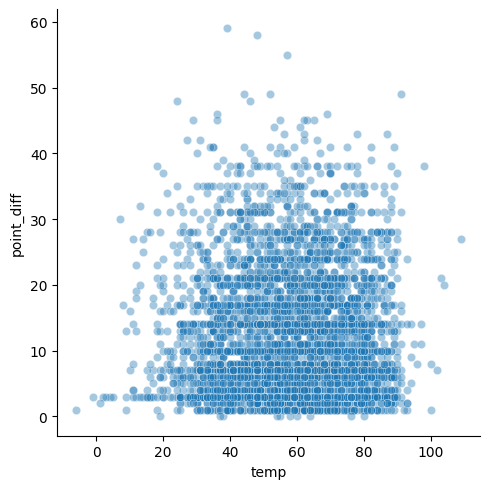

In [18]:
sns.relplot(
    x="temp",
    y="point_diff",
    data=df[pd.notnull(df['wind'])],
    kind="scatter",
    alpha=0.4
)

plt.show()

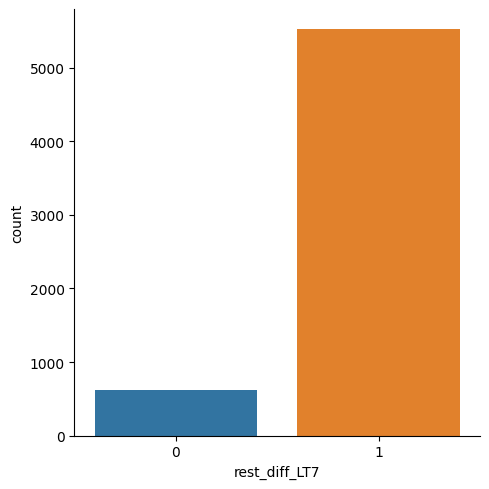

In [87]:
sns.catplot(
    x="rest_diff_LT7",
    data=df,
    kind="count"
)
plt.show()

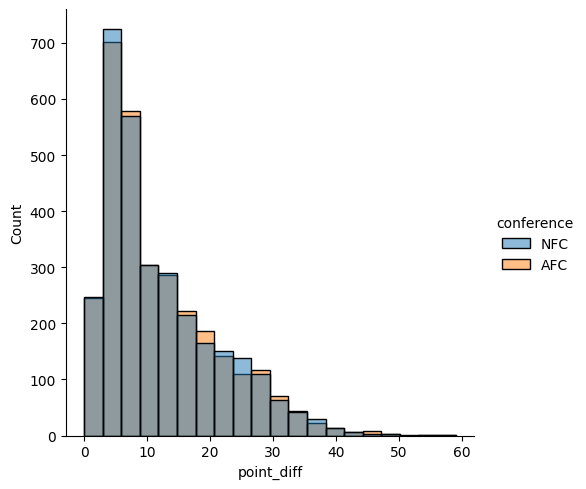

In [20]:
sns.displot(
    x="point_diff",
    data=df,
    kind="hist",
    bins=20,
    hue='conference'
)

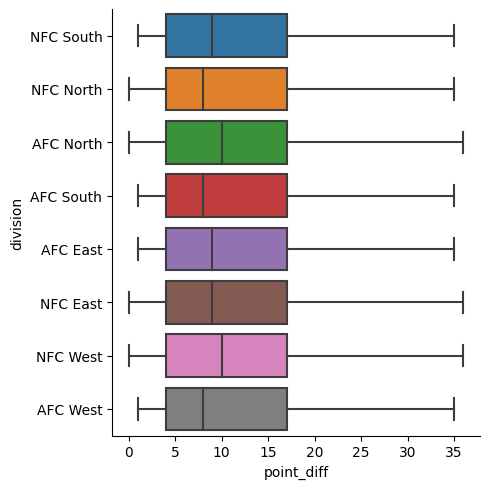

In [25]:
sns.catplot(
    x="point_diff",
    y="division",
    data=df,
    kind="box",
    showfliers=False
)
plt.show()

### Finding Outliers

In [86]:
q1 = df[df['is_playoffs'] == '1']['point_diff'].quantile(0.25)
q3 = df[df['is_playoffs'] == '1']['point_diff'].quantile(0.75)

iqr = 1.5 * (q3 - q1)

df[(df['is_playoffs'] == '1') & ((df['point_diff']) > (q3 + iqr))]

,game_id,season,game_type,is_playoffs,week,away_team,away_score,home_team,home_score,point_diff,...,is_dome,surface,temp,wind,away_rest,home_rest,rest_diff,rest_diff_LT7,weekday,div_game
252,1999_19_MIA_JAX,1999,DIV,1,19,MIA,7.0,JAX,62.0,55.0,...,0,grass,57.0,14.0,6,13,7,0,Saturday,0
515,2000_20_MIN_NYG,2000,CON,1,20,MIN,0.0,NYG,41.0,41.0,...,0,grass,35.0,5.0,8,7,1,1,Sunday,0
1033,2002_18_IND_NYJ,2002,WC,1,18,IND,0.0,NYJ,41.0,41.0,...,0,grass,35.0,10.0,6,6,0,1,Saturday,0
4246,2014_20_IND_NE,2014,CON,1,20,IND,7.0,NE,45.0,38.0,...,0,fieldturf,51.0,15.0,7,8,1,1,Sunday,0


In [14]:
pd.read_sql("""
    WITH data AS (
    SELECT
        game_id,
        season,
        game_type,
        week,
        away_team,
        away_score,
        -- Need to update data to account for 3 teams that switched cities between 1999-2020
        CASE
            WHEN home_team = 'STL' THEN 'LAR'
            WHEN home_team = 'SD' THEN 'LAC'
            WHEN home_team = 'OAK' THEN 'LV'
            ELSE home_team
        END AS home_team,
        home_score,
        ABS(home_score - away_score) AS point_diff,
        roof,
        surface,
        temp,
        wind,
        away_rest,
        home_rest,
        ABS(home_rest - away_rest) AS rest_diff,
        weekday 
    FROM schedules
    )
    SELECT 
    round(((SELECT COUNT(*) FROM data WHERE point_diff >= 50) * 1.0) / COUNT(*) * 100,2) AS pct_of_gte50
    FROM data
    
""", conn)

,pct_of_gte50
0,0.08


In [36]:
def get_outliers(df, quantile, category, num):

    dict = {}
    
    for value in df[category].unique():
        
        filter_category = (df[category] == value)
        quantile = df[filter_category].quantile(quantile)
        print(quantile)

        outliers = df[filter_category & (df[value] > quantile)]

        print(outliers)

        dict[value] = outliers

    return dict

In [37]:
get_outliers(df, 0.75, 'game_type', 'score')

season    2016.0
week        14.0
score       29.0
Name: 0.75, dtype: float64


/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_32641/594948404.py:8: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantile = df[filter_category].quantile(quantile)


KeyError: 'REG'

In [35]:
for i in df['game_type'].unique():
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
